In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


/home/khabilan/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
words = open("names.txt" , "r").read().splitlines()

In [7]:
print(f"Number of words : {len(words)}")

Number of words : 32033


In [8]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s , i in stoi.items()}

In [140]:
# Dataset Preperation
block_size = 3

X = []
y = []


for word in words:
    context = [0] * block_size
    word = list(word) + ['.']
    
    for ch in word:
        idx = stoi[ch]
        
        X.append(context)
        y.append(idx)
        
        context = context[1:] + [idx]
    
n1 = int(0.8 * len(X))
n2 = int(0.9 * len(X))

X_train = torch.tensor(X[:n1])
y_train = torch.tensor(y[:n1])
X_val = torch.tensor(X[n1:n2])
y_val = torch.tensor(y[n1:n2])
X_test = torch.tensor(X[n2:])
y_test = torch.tensor(y[n2:])

In [258]:
# Trainable Parameters
neuron_size = 300
embed_size = 10
input_size = 27

tanh_gain = 5 / 3
std = tanh_gain / ((embed_size * block_size) ** 0.5)
print(f"{std=}")

C = torch.randn((27,embed_size))
W1 = torch.randn((embed_size * block_size,neuron_size)) * std
b1 = torch.randn(neuron_size) * std
W2 = torch.randn((neuron_size,27)) * std
b2 = torch.randn(27) * std
bngain = torch.ones(300)
bnbias = torch.zeros(300)

bnmean_running = torch.ones((1 , 300))
bnstd_running = torch.zeros((1 , 300))

parameters = [W1 , W2 , b1 , b2 , C , bngain , bnbias]
print(f"Number of trainable parameters : {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

std=0.3042903097250923
Number of trainable parameters : 18297


In [276]:
batch_size = 32
learning_rate = 1e-1

step_i = []
loss_i = []

for i in range(100000):
    idx = torch.randint(len(X_train) , (batch_size,))
    
    xb = X_train[idx]
    yb = y_train[idx]
    
    # Forward Pass
    x = C[xb]
    x = x.view(-1,C.shape[1] * block_size) @ W1 + b1
    
    # Normalization
    bnmean = x.mean(0 , keepdim=True)
    bnstd = x.std(0 , keepdim=True) 
    x = bngain * ((x - bnmean) / bnstd) + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd

    x = torch.tanh(x)
    x = x @ W2 + b2
    loss = F.cross_entropy(x , yb)
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -learning_rate*p.grad
    
    step_i.append(i)
    loss_i.append(loss.item())
    
    if i % 1000 == 0:
        print(f"{i} / 100000: {loss=}")

0 / 100000: loss=tensor(2.2922, grad_fn=<NllLossBackward0>)
1000 / 100000: loss=tensor(2.4057, grad_fn=<NllLossBackward0>)
2000 / 100000: loss=tensor(1.6277, grad_fn=<NllLossBackward0>)
3000 / 100000: loss=tensor(2.2330, grad_fn=<NllLossBackward0>)
4000 / 100000: loss=tensor(2.4119, grad_fn=<NllLossBackward0>)
5000 / 100000: loss=tensor(1.9763, grad_fn=<NllLossBackward0>)
6000 / 100000: loss=tensor(2.4836, grad_fn=<NllLossBackward0>)
7000 / 100000: loss=tensor(2.4118, grad_fn=<NllLossBackward0>)
8000 / 100000: loss=tensor(2.4049, grad_fn=<NllLossBackward0>)
9000 / 100000: loss=tensor(2.8746, grad_fn=<NllLossBackward0>)
10000 / 100000: loss=tensor(2.1118, grad_fn=<NllLossBackward0>)
11000 / 100000: loss=tensor(2.0257, grad_fn=<NllLossBackward0>)
12000 / 100000: loss=tensor(1.9596, grad_fn=<NllLossBackward0>)
13000 / 100000: loss=tensor(1.7997, grad_fn=<NllLossBackward0>)
14000 / 100000: loss=tensor(2.1813, grad_fn=<NllLossBackward0>)
15000 / 100000: loss=tensor(2.1118, grad_fn=<NllLossB

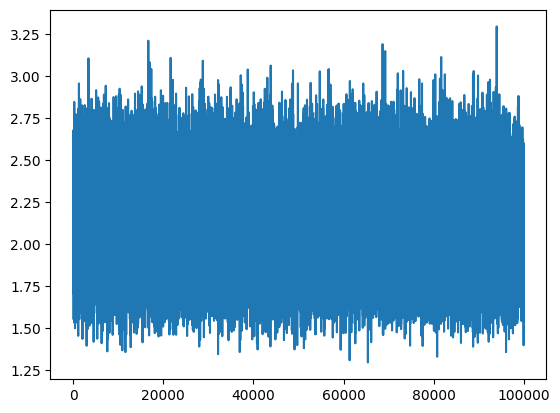

In [277]:
plt.plot( step_i, loss_i)

In [278]:
# Test Loss
x = C[X_train]
x = x.view(-1,C.shape[1] * block_size) @ W1 + b1
x = bngain * ((x - bnmean_running) / bnstd_running) + bnbias
x = torch.tanh(x)
x = x @ W2 + b2
loss = F.cross_entropy(x , y_train)

print(f"Train {loss=}")

# Test Loss
x = C[X_test]
x = x.view(-1,C.shape[1] * block_size) @ W1 + b1
x = bngain * ((x - bnmean_running) / bnstd_running) + bnbias
x = torch.tanh(x)
x = x @ W2 + b2
loss = F.cross_entropy(x , y_test)

print(f"Test {loss=}")

Train loss=tensor(2.0769, grad_fn=<NllLossBackward0>)
Test loss=tensor(2.4232, grad_fn=<NllLossBackward0>)


In [287]:
x = (C[X_test[:32]].view(-1 , 30) @ W1)
bnmean1 = x.mean(0 , keepdim=True)
x.shape , bnmean1.shape

(torch.Size([32, 300]), torch.Size([1, 300]))

In [279]:
g = torch.Generator().manual_seed(12151)

for _ in range(20):
    
    out = ['k' , 'h' ]
    # context = [0] * block_size
    context = [0, stoi['k'] , stoi['h']]
    while True:
        # Forward Passing
        x = C[context]
        x = x.view(-1,C.shape[1] * block_size) @ W1 + b1
        x = bngain * ((x - bnmean_running) / bnstd_running) + bnbias
        x = torch.tanh(x)
        x = x @ W2 + b2
        probx = F.softmax(x , dim=1)
        
        ix = torch.multinomial(probx , num_samples=1 , generator=g).item()        
        if ix == 0:
            break
        
        context = context[1:] + [ix]
        out.append(itos[ix])
    
    print(''.join(out))

khal
kherman
khy
kharmaser
kharneha
khaida
kheriya
kharalynn
khariyabeth
kherik
khyanna
khalynn
khankeyla
khan
khaela
kheus
khargustefan
khari
khan
khalima
